In [1]:
import numpy as np
from math import sqrt
from sklearn import preprocessing
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
data = np.loadtxt("data/spambase.data", dtype='f', delimiter=',')

print (data)
print (data.dtype)        

[[0.000e+00 6.400e-01 6.400e-01 ... 6.100e+01 2.780e+02 1.000e+00]
 [2.100e-01 2.800e-01 5.000e-01 ... 1.010e+02 1.028e+03 1.000e+00]
 [6.000e-02 0.000e+00 7.100e-01 ... 4.850e+02 2.259e+03 1.000e+00]
 ...
 [3.000e-01 0.000e+00 3.000e-01 ... 6.000e+00 1.180e+02 0.000e+00]
 [9.600e-01 0.000e+00 0.000e+00 ... 5.000e+00 7.800e+01 0.000e+00]
 [0.000e+00 0.000e+00 6.500e-01 ... 5.000e+00 4.000e+01 0.000e+00]]
float32


Isso mostra que teremos que tratar os dados antes de rodar __Online SVM via Online Gradient Descent__

Temos ao menos duas etapas:
1 - Transformar os valores de classe ( variável target ) de 0, 1 para -1 ,1
2 - Temos que fazer uma normalização dos parâmetros. Pois alguns dados são percentuais e estão no range [0, 100] e outros podem atingir valores maiores como por exemplo 15841. Não queremos que um atributo tenha uma importância maior que outro por ser representado em uma escala diferente. Vamos fazer uma normalização __hard__ que é mapear o maior valor de uma determinada feature para 1 e dividir os outros valores dessa feature específica pelo maior valor encontrado.

Se a normalização hard se mostrar ruim na prática, podemos pensar em outras normalizações. ( Soft usando mediana e desvio-padrão )..



In [3]:
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(data)

for entry in x_scaled:
    if entry[57] < 1:
        entry[57] = -1.0

In [4]:
x_scaled

array([[ 0.00000000e+00,  4.48179282e-02,  1.25490189e-01, ...,
         6.00720895e-03,  1.74873751e-02,  1.00000000e+00],
       [ 4.62555066e-02,  1.96078438e-02,  9.80392173e-02, ...,
         1.00120148e-02,  6.48358613e-02,  1.00000000e+00],
       [ 1.32158585e-02,  0.00000000e+00,  1.39215678e-01, ...,
         4.84581478e-02,  1.42550513e-01,  1.00000000e+00],
       ...,
       [ 6.60792962e-02,  0.00000000e+00,  5.88235334e-02, ...,
         5.00600727e-04,  7.38636404e-03, -1.00000000e+00],
       [ 2.11453736e-01,  0.00000000e+00,  0.00000000e+00, ...,
         4.00480581e-04,  4.86111175e-03, -1.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.27450973e-01, ...,
         4.00480581e-04,  2.46212143e-03, -1.00000000e+00]], dtype=float32)

Breve descrição de Online SVM via Online Gradient Descent
* No instante t
    * Selecionamos um vetor pt
    * Recebemos uma nova instância do dataset (yt, zt), onde yt são os atributos e zt é a classe correspondente
    * Vamos tomar uma Hinge Loss definida como max(0, 1 - zt * <pt, yt> )
    * Utilizaremos o gradiente da função de perda do instante t para calcular o próximo p(t+1)
    
Vamos também utilizar sempre pt pertencente ao espaço euclideano de norma <= 1.

A princípio o p0 pode ser definido arbitrariamente, mas como vimos descrito em alguns lugares da literatura a inicialização com o vetor nulo vamos adotar essa estratégia.
   

In [5]:
# Aqui algumas funções auxiliares úteis
def hinge_loss(p_t, z_t, y_t):
    return max(0, 1 - np.dot(p_t, y_t) * z_t )

def project_into_euclidean_norm_1( p_t ):
    norm = np.linalg.norm(p_t)
    norm_p = p_t.copy()
    if norm <= 1:
        return norm_p
    else:
        norm_p = np.true_divide( norm_p, norm )
        return norm_p

In [6]:
def online_svm(data, eta_fnc):
    current_p = np.zeros(57)
    did_classify_correctly = np.zeros(len(data))
    all_p = [ current_p ]
    cumulative_loss = 0
    # Agora vamos processar o dataset uma instancia de cada vez, num setup online
    t = 1

    for instance in data:
        instance_features = instance[0:57] # slices are semi-open intervals (:, [0, 57)
        target_class = instance[57]
        # vamos tomar a perda hinge relativo a current_p
        current_loss = hinge_loss( current_p, target_class, instance_features )
        dot_prod = np.dot( current_p, instance_features )
        predicted_class =  -1
        if dot_prod >= 0:
            predicted_class =  1
        did_classify_correctly[t-1] = (target_class == predicted_class)
        
        cumulative_loss += current_loss
        # Agora vamos usar o gradiente / subgradiente para fazer a atualizacao de p_(t + 1)
        # Se hinge_loss = 0, posso usar o subgradiente definido pela reta y = 0, e não mexer em p_t

        # O caso de fato interessante é quando a perda é positiva e queremos seguir no sentido contrário do subgradiente
        if current_loss > 0:
            gradient = instance_features * (-target_class) # derivada
            current_eta = eta_fnc( t ) # Eta calculado em funcao de t, de acordo com a funcao recebida como parametro
            
            # p_t = p_(t - 1) - eta_t * ( gradiente da função de perda )
            current_p -= current_eta * gradient
            current_p = project_into_euclidean_norm_1( current_p )
            
        tmp = np.append(all_p, [current_p], axis = 0 ) # Adding current support vector to the list
        all_p = tmp.copy()
        
        t += 1 # increment in one the number of processed instances
    return {"p": all_p, "did_classify_correctly": did_classify_correctly}

In [7]:
def eta( t ):
    return 1 / sqrt(t)

In [8]:
test_data = x_scaled.copy()

results = online_svm( test_data, eta )
p = results["p"]
did_classify_correctly_not_shuffled = results["did_classify_correctly"]

np.random.seed(1)
np.random.shuffle( test_data )

results2 = online_svm( test_data, eta )
p2 = results2["p"]
did_classify_correctly_shuffled = results2["did_classify_correctly"]

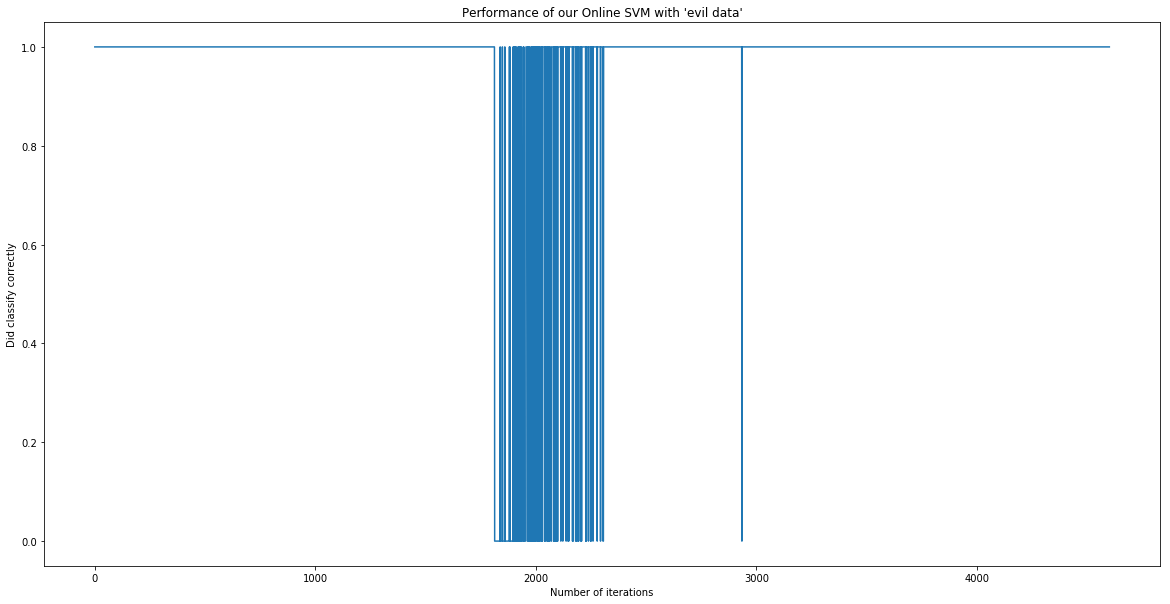

In [9]:
iterations = range(len(data))
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(iterations, did_classify_correctly_not_shuffled)
plt.xlabel('Number of iterations')
plt.ylabel('Did classify correctly')
plt.title('Performance of our Online SVM with \'evil data\'')
plt.show()

In [10]:
unshuffled_df = pd.DataFrame(did_classify_correctly_not_shuffled, columns=["is_correct"])
shuffled_df = pd.DataFrame(did_classify_correctly_shuffled, columns=["is_correct"])

In [11]:
len(data)

4601

In [12]:
incorrect_unshuffled = unshuffled_df[unshuffled_df["is_correct"] == False]

In [13]:
incorrect_shuffled = shuffled_df[shuffled_df["is_correct"] == False]

In [14]:
accuracy_unshuffled = 1 - len(incorrect_unshuffled) / len(data)
accuracy_shuffled = 1 - len(incorrect_shuffled) / len(data)

In [15]:
print(accuracy_unshuffled)
print(accuracy_shuffled)

0.9547924364268637
0.7546185611823517


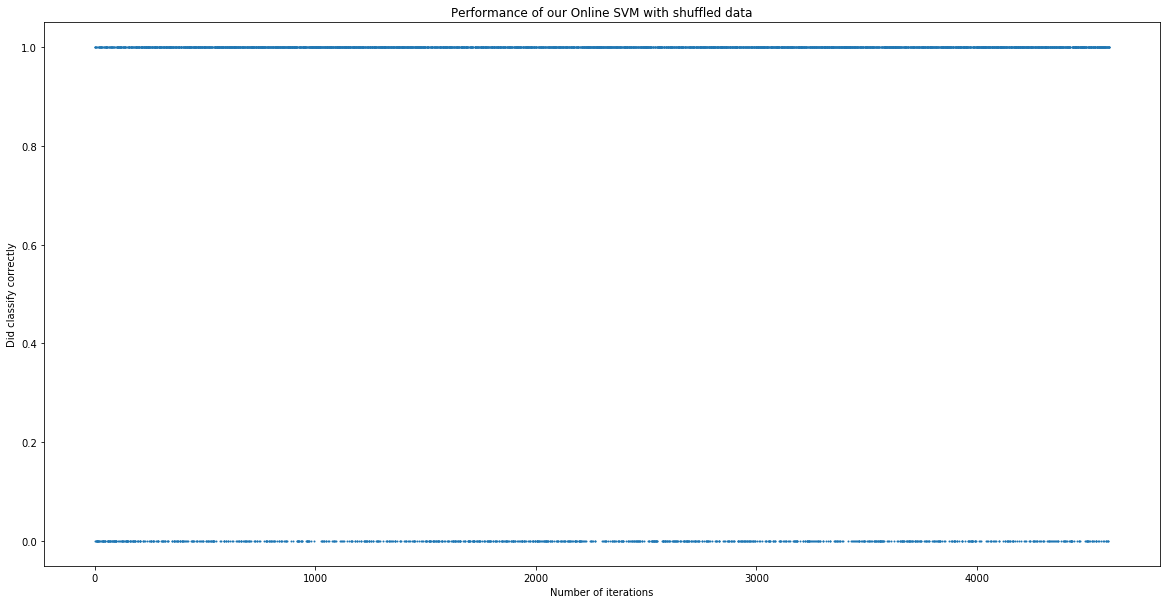

In [16]:
plt.rcParams["figure.figsize"] = (20,10)
plt.scatter(iterations, did_classify_correctly_shuffled, 1)
plt.xlabel('Number of iterations')
plt.ylabel('Did classify correctly')
plt.title('Performance of our Online SVM with shuffled data')
plt.show()